Необработанные сетевые пакеты набора данных UNSW-NB 15 были созданы инструментом IXIA PerfectStorm в Лаборатории Cyber Range Австралийского центра кибербезопасности (ACCS) для создания гибрида реальных современных обычных действий и синтетического современного поведения при атаках.


###Изучение данных

Подключаем нужные для работы библиотеки

In [112]:
from google.colab import drive
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder,normalize
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Загружаем данные

In [113]:
data_train = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/homeWork/2022/project/data/UNSW_NB15_training-set.csv', delimiter=',')

In [156]:
data_train.shape

(82332, 45)

In [114]:
data_test = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/homeWork/2022/project/data/UNSW_NB15_testing-set.csv', delimiter=',')

In [157]:
data_test.shape

(175341, 43)

Для обработки данных будем использавать набор данных train

In [115]:
data = pd.concat([data_train], ignore_index=True)

In [116]:
data.tail()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
82327,82328,0.000005,udp,-,INT,2,0,104,0,200000.005100,...,1,2,0,0,0,2,1,0,Normal,0
82328,82329,1.106101,tcp,-,FIN,20,8,18062,354,24.410067,...,1,1,0,0,0,3,2,0,Normal,0
82329,82330,0.000000,arp,-,INT,1,0,46,0,0.000000,...,1,1,0,0,0,1,1,1,Normal,0
82330,82331,0.000000,arp,-,INT,1,0,46,0,0.000000,...,1,1,0,0,0,1,1,1,Normal,0
82331,82332,0.000009,udp,-,INT,2,0,104,0,111111.107200,...,1,1,0,0,0,1,1,0,Normal,0


Функция для удаления лишних колонок

In [117]:
def drop_col(col_names, dataframe):
  dataframe.drop(col_names, axis=1, inplace=True)

In [118]:
drop_col(['id'], data)

Рассмотрим какие уникальные значения есть в колонках label, attack_cat

In [119]:
data.label.value_counts()

1    45332
0    37000
Name: label, dtype: int64

In [120]:
data.attack_cat.value_counts()

Normal            37000
Generic           18871
Exploits          11132
Fuzzers            6062
DoS                4089
Reconnaissance     3496
Analysis            677
Backdoor            583
Shellcode           378
Worms                44
Name: attack_cat, dtype: int64

Строим гистраграммы, чтобы проверить распределение, видим неравномерное распределение например smean

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f63edd34850>,
      dtype=object)

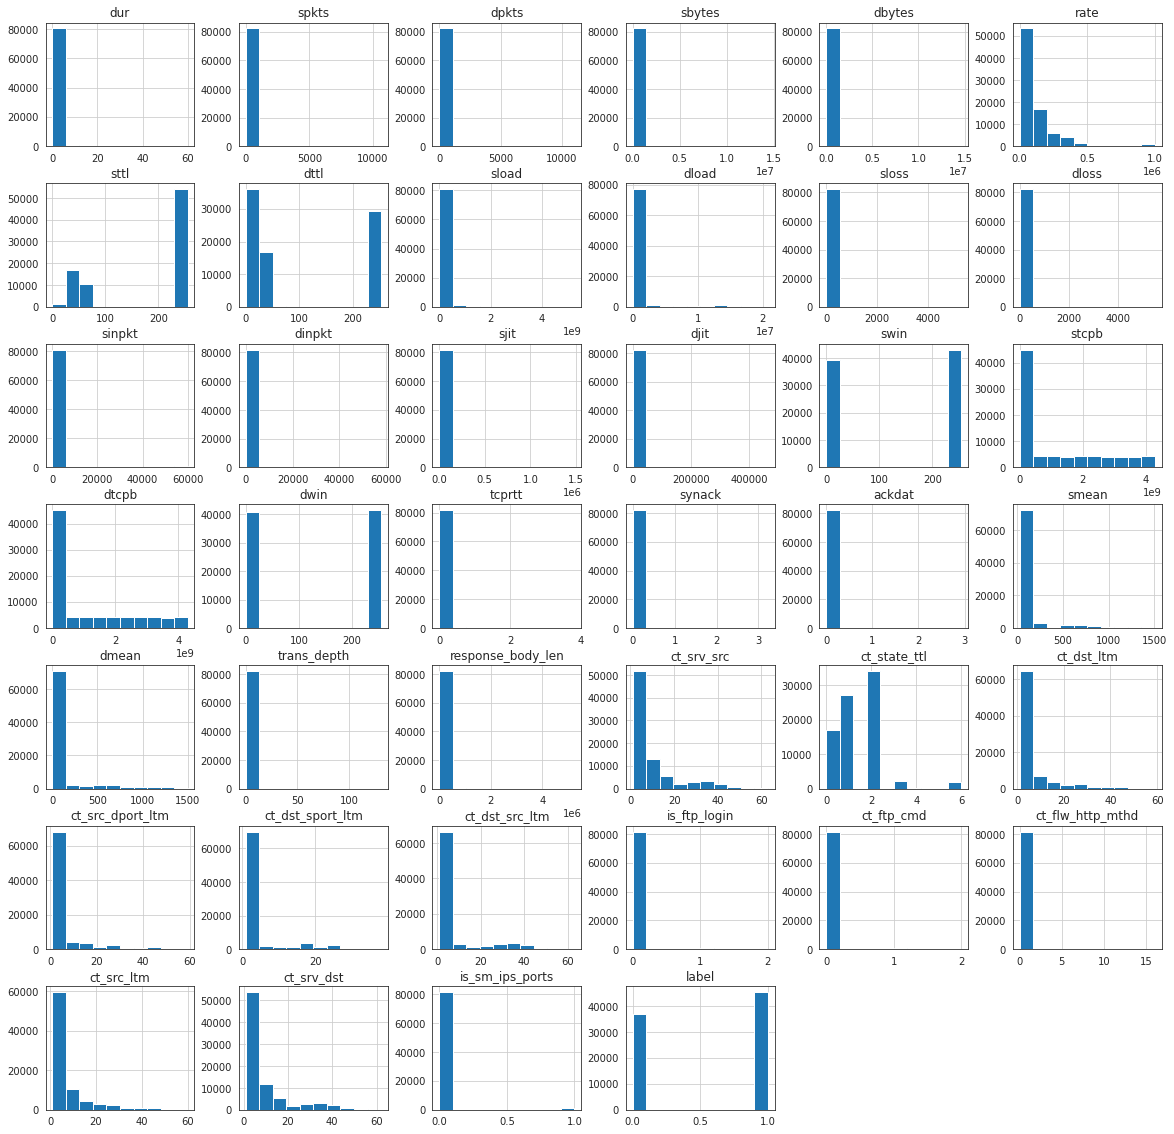

In [121]:
data.hist(figsize=(20, 20))

Строим таблицу корреляции чтобы узнать какие данные наиболее коррелируют друг с другом, а также с target колонкой label

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



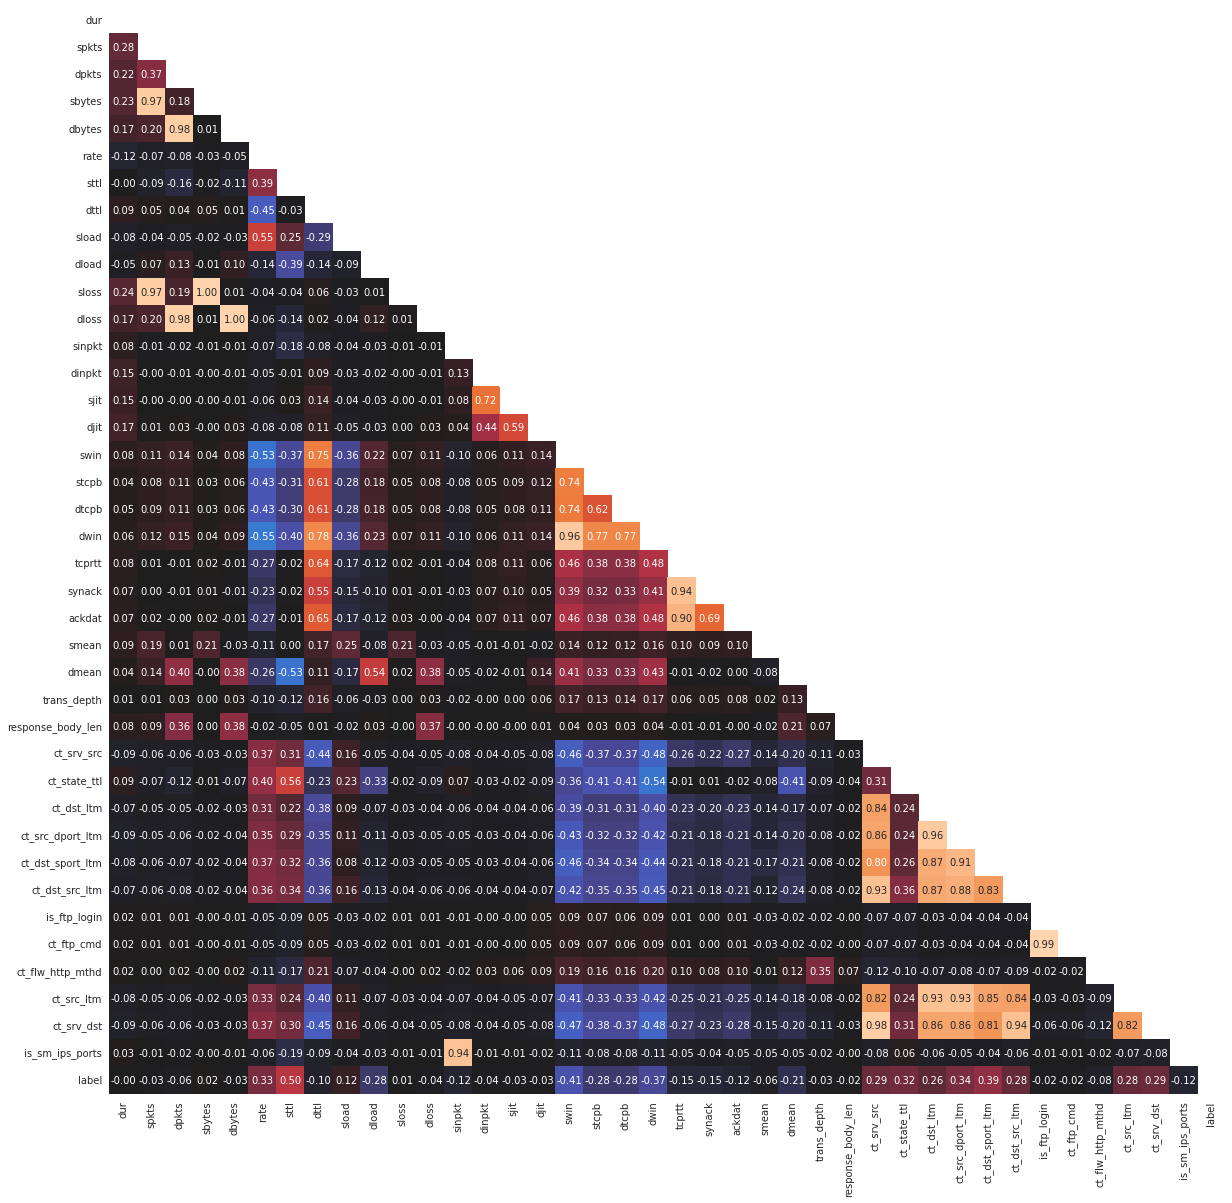

In [122]:
plt.figure(figsize=(20,20))

corr_matrix = data.corr()
lower = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(np.bool))

sns.heatmap(lower, annot=True, fmt='.2f', cbar=False, center=0);

С помощью describe выводим статистические данные, которые дают представление о распределении значений.

In [123]:
data.describe(include='all')

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
count,82332.000000,82332,82332,82332,82332.000000,82332.000000,8.233200e+04,8.233200e+04,8.233200e+04,82332.000000,...,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332,82332.000000
unique,NaN,131,13,7,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,NaN
top,NaN,tcp,-,FIN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,NaN
freq,NaN,43095,47153,39339,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37000,NaN
mean,1.006756,NaN,NaN,NaN,18.666472,17.545936,7.993908e+03,1.323379e+04,8.241089e+04,180.967667,...,3.663011,7.456360,0.008284,0.008381,0.129743,6.468360,9.164262,0.011126,NaN,0.550600
std,4.710444,NaN,NaN,NaN,133.916353,115.574086,1.716423e+05,1.514715e+05,1.486204e+05,101.513358,...,5.915386,11.415191,0.091171,0.092485,0.638683,8.543927,11.121413,0.104891,NaN,0.497436
min,0.000000,NaN,NaN,NaN,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000e+00,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,NaN,0.000000
25%,0.000008,NaN,NaN,NaN,2.000000,0.000000,1.140000e+02,0.000000e+00,2.860611e+01,62.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,NaN,0.000000
50%,0.014138,NaN,NaN,NaN,6.000000,2.000000,5.340000e+02,1.780000e+02,2.650177e+03,254.000000,...,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,5.000000,0.000000,NaN,1.000000
75%,0.719360,NaN,NaN,NaN,12.000000,10.000000,1.280000e+03,9.560000e+02,1.111111e+05,254.000000,...,3.000000,6.000000,0.000000,0.000000,0.000000,7.000000,11.000000,0.000000,NaN,1.000000


Видим что есть нечисловые значения. И выделяем для начала только их. Сразу замечаем что например колонка dur имеет завышенный max относильтельно mean значит как мимнимум в этой колнке есть выбросы

In [124]:
data_numeric = data.select_dtypes(include=[np.number])
data_numeric.describe(include='all')

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
count,82332.000000,82332.000000,82332.000000,8.233200e+04,8.233200e+04,8.233200e+04,82332.000000,82332.000000,8.233200e+04,8.233200e+04,...,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000
mean,1.006756,18.666472,17.545936,7.993908e+03,1.323379e+04,8.241089e+04,180.967667,95.713003,6.454902e+07,6.305470e+05,...,4.928898,3.663011,7.456360,0.008284,0.008381,0.129743,6.468360,9.164262,0.011126,0.550600
std,4.710444,133.916353,115.574086,1.716423e+05,1.514715e+05,1.486204e+05,101.513358,116.667722,1.798618e+08,2.393001e+06,...,8.389545,5.915386,11.415191,0.091171,0.092485,0.638683,8.543927,11.121413,0.104891,0.497436
min,0.000000,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,0.000008,2.000000,0.000000,1.140000e+02,0.000000e+00,2.860611e+01,62.000000,0.000000,1.120247e+04,0.000000e+00,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000
50%,0.014138,6.000000,2.000000,5.340000e+02,1.780000e+02,2.650177e+03,254.000000,29.000000,5.770032e+05,2.112951e+03,...,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,5.000000,0.000000,1.000000
75%,0.719360,12.000000,10.000000,1.280000e+03,9.560000e+02,1.111111e+05,254.000000,252.000000,6.514286e+07,1.585808e+04,...,4.000000,3.000000,6.000000,0.000000,0.000000,0.000000,7.000000,11.000000,0.000000,1.000000
max,59.999989,10646.000000,11018.000000,1.435577e+07,1.465753e+07,1.000000e+06,255.000000,253.000000,5.268000e+09,2.082111e+07,...,59.000000,38.000000,63.000000,2.000000,2.000000,16.000000,60.000000,62.000000,1.000000,1.000000


Здесь мы определяем какие параметры имеют max котрый превышавет в 10 раз median, следовательно имеет выбросы, нормализуем эти данные преобразуя их по 95% квантили

In [125]:
def normalize_data(data_numeric):
  for feature in data_numeric.columns:
    print(feature)
    print('max = '+str(data_numeric[feature].max()))
    print('75th = '+str(data_numeric[feature].quantile(0.95)))
    print('median = '+str(data_numeric[feature].median()))
    print(data_numeric[feature].max()>10*data_numeric[feature].median())
    print('----------------------------------------------------')
    if data_numeric[feature].max()>10*data_numeric[feature].median() and data_numeric[feature].max()>10 :
        data[feature] = np.where(data[feature]<data[feature].quantile(0.95), data[feature], data[feature].quantile(0.95))

In [126]:
normalize_data(data_numeric)

dur
max = 59.999989
75th = 2.403792249999999
median = 0.014138
True
----------------------------------------------------
spkts
max = 10646
75th = 60.0
median = 6.0
True
----------------------------------------------------
dpkts
max = 11018
75th = 54.0
median = 2.0
True
----------------------------------------------------
sbytes
max = 14355774
75th = 12472.0
median = 534.0
True
----------------------------------------------------
dbytes
max = 14657531
75th = 30622.0
median = 178.0
True
----------------------------------------------------
rate
max = 1000000.003
75th = 333333.3215
median = 2650.176667
True
----------------------------------------------------
sttl
max = 255
75th = 254.0
median = 254.0
False
----------------------------------------------------
dttl
max = 253
75th = 252.0
median = 29.0
False
----------------------------------------------------
sload
max = 5268000256.0
75th = 266666656.0
median = 577003.21875
True
----------------------------------------------------
dload
max

Видим что числовые данные теперь нормализованы, например в колонке dur max теперь не равен 60 а 2, что приближенно к mean значению

In [127]:
data_numeric = data.select_dtypes(include=[np.number])
data_numeric.describe(include='all')

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
count,82332.000000,82332.00000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,8.233200e+04,8.233200e+04,...,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000
mean,0.445016,11.84186,9.178424,1580.566135,2866.918367,71576.702810,180.967667,95.713003,4.649418e+07,3.105380e+05,...,4.466611,3.388901,7.160679,0.008284,0.008381,0.092066,5.974809,8.832532,0.011126,0.550600
std,0.672222,15.66461,14.504212,2948.850472,7525.606738,102631.946851,101.513358,116.667722,7.417784e+07,8.918691e+05,...,6.685037,5.029129,10.481621,0.091171,0.092485,0.289121,6.867156,10.124902,0.104891,0.497436
min,0.000000,1.00000,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,0.000008,2.00000,0.000000,114.000000,0.000000,28.606114,62.000000,0.000000,1.120247e+04,0.000000e+00,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000
50%,0.014138,6.00000,2.000000,534.000000,178.000000,2650.176667,254.000000,29.000000,5.770032e+05,2.112951e+03,...,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,5.000000,0.000000,1.000000
75%,0.719360,12.00000,10.000000,1280.000000,956.000000,111111.107200,254.000000,252.000000,6.514286e+07,1.585808e+04,...,4.000000,3.000000,6.000000,0.000000,0.000000,0.000000,7.000000,11.000000,0.000000,1.000000
max,2.403792,60.00000,54.000000,12472.000000,30622.000000,333333.321500,255.000000,253.000000,2.666667e+08,3.741446e+06,...,25.000000,18.000000,37.000000,2.000000,2.000000,1.000000,25.000000,36.000000,1.000000,1.000000


Здесь рассматриваем категориальные данные

In [128]:
data_cat = data.select_dtypes(exclude=[np.number])
data_cat.describe(include='all')

,proto,service,state,attack_cat
count,82332,82332,82332,82332
unique,131,13,7,10
top,tcp,-,FIN,Normal
freq,43095,47153,39339,37000


In [129]:
cols_cat = ['proto', 'service', 'state']

Были замечены '-' в данных, создаем функция для преобразование прочерков в None

In [130]:
def remove_dump_values(data, cols):
    for col in cols:
        data[col] = np.where(data[col] == '-', 'None', data[col])
    return data

In [131]:
remove_dump_values(data, cols_cat)

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.000011,udp,None,INT,2.0,0.0,496.0,0.0,90909.090200,254,...,1.0,2.0,0,0,0.0,1.0,2.0,0,Normal,0
1,0.000008,udp,None,INT,2.0,0.0,1762.0,0.0,125000.000300,254,...,1.0,2.0,0,0,0.0,1.0,2.0,0,Normal,0
2,0.000005,udp,None,INT,2.0,0.0,1068.0,0.0,200000.005100,254,...,1.0,3.0,0,0,0.0,1.0,3.0,0,Normal,0
3,0.000006,udp,None,INT,2.0,0.0,900.0,0.0,166666.660800,254,...,1.0,3.0,0,0,0.0,2.0,3.0,0,Normal,0
4,0.000010,udp,None,INT,2.0,0.0,2126.0,0.0,100000.002500,254,...,1.0,3.0,0,0,0.0,2.0,3.0,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,0.000005,udp,None,INT,2.0,0.0,104.0,0.0,200000.005100,254,...,1.0,2.0,0,0,0.0,2.0,1.0,0,Normal,0
82328,1.106101,tcp,None,FIN,20.0,8.0,12472.0,354.0,24.410067,254,...,1.0,1.0,0,0,0.0,3.0,2.0,0,Normal,0
82329,0.000000,arp,None,INT,1.0,0.0,46.0,0.0,0.000000,0,...,1.0,1.0,0,0,0.0,1.0,1.0,1,Normal,0
82330,0.000000,arp,None,INT,1.0,0.0,46.0,0.0,0.000000,0,...,1.0,1.0,0,0,0.0,1.0,1.0,1,Normal,0


Прежде чем преобразоввывать убедимся что они влияют на построение модели с помощью SelectKBest

Метод SelectKBest выбирает функции в соответствии с наивысшим значением k . Изменив параметр «score_func», мы можем применить метод как к данным классификации, так и к данным регрессии. Выбор лучших функций — важный процесс, когда мы готовим большой набор данных для обучения.


Выводим топ 20 features,в качесте target выбираем последнюю колонку label


In [132]:
from sklearn.feature_selection import SelectKBest, chi2

best_features = SelectKBest(score_func=chi2,k='all')

X = data.iloc[:,4:-2]
y = data.iloc[:,-1]
fit = best_features.fit(X,y)

data_scores=pd.DataFrame(fit.scores_)
data_col=pd.DataFrame(X.columns)

feature_score=pd.concat([data_col,data_scores],axis=1)
feature_score.columns=['feature','score']
feature_score.sort_values(by=['score'],ascending=True,inplace=True)

fig = go.Figure(go.Bar(
            x=feature_score['score'][0:21],
            y=feature_score['feature'][0:21],
            orientation='h'))

fig.update_layout(title="Top 20 Features",
                  height=1200,
                  showlegend=False,
                 )

fig.show()

Убираем данные ненужные колонки в dataframe

In [133]:
list_drop = ['attack_cat']
drop_col(list_drop,data)

Функция для преобразование категориальных данных в числовые через LabelEncoder

Sklearn предоставляет очень эффективный инструмент для кодирования уровней категориальных признаков в числовые значения. LabelEncoder кодирует метки со значением от 0 до n_classes-1, где n — количество различных меток . Если метка повторяется, она присваивает то же значение, что и ранее.


In [134]:
def label_encoder_transform(data, cols_cat):
  le = LabelEncoder()
  for col in cols_cat:
    data[col] = le.fit_transform(data[col])

In [135]:
label_encoder_transform(data,cols_cat)

###Обучение данных

Вынесем из датасеты label переменную, и разобьем наши данные на test и train

---



In [136]:
data_x = data.drop(['label'], axis=1)
data_y = data.loc[:,['label']]

X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=.20, random_state=42, stratify=data_y)

Заранее создадим список из feature для графиков

In [137]:
feature_names = list(data_x.columns)

In [138]:
!python -m pip install pyod

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Все данные об обучении в виде метрик и времени обучения вынесем в отдельную переменную для удобства

In [139]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import plot_confusion_matrix # will plot the confusion matrix
import time
model_performance = pd.DataFrame(columns=['Accuracy','Recall','Precision','F1-Score','time to train','time to predict','total time'])

####Isolation forest

Изолирующий лес - алгоритм обнаружения аномалий. Он обнаруживает аномалии, используя изоляцию (насколько далеко точка данных находится от остальных данных), а не моделируя нормальные точки. Изолирующий лес представляет метод, который явно изолирует аномалии с помощью бинарных деревьев, демонстрируя новую возможность более быстрого детектора аномалий, который непосредственно нацелен на аномалии без профилирования всех нормальных экземпляров.

В основе алгоритма изолированного леса лежит тенденция аномальных экземпляров в наборе данных легче отделить от остальной выборки (изолировать) по сравнению с нормальными точками. Чтобы изолировать точку данных, алгоритм рекурсивно создает разделы выборки, случайным образом выбирая атрибут, а затем случайным образом выбирая значение разделения для атрибута между минимальным и максимальным значениями, разрешенными для этого атрибута.


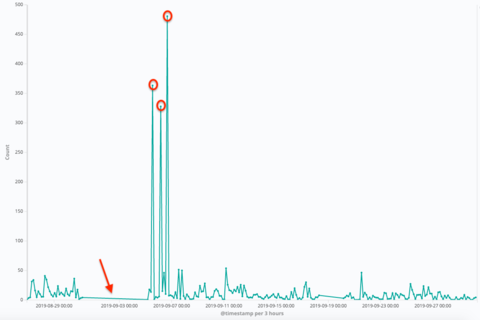

In [140]:
%%time
start = time.time()
model = IsolationForest(n_estimators=500).fit(X_train,y_train)
end_train = time.time()
y_predictions = model.predict(X_test) # These are the predictions from the test data.
end_predict = time.time()

CPU times: user 16.2 s, sys: 562 ms, total: 16.8 s
Wall time: 22.9 s


In [141]:
accuracy = accuracy_score(y_test, y_predictions)
recall = recall_score(y_test, y_predictions, average='weighted')
precision = precision_score(y_test, y_predictions, average='weighted')
f1s = f1_score(y_test, y_predictions, average='weighted')

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("time to train: "+ "{:.2f}".format(end_train-start)+" s")
print("time to predict: "+"{:.2f}".format(end_predict-end_train)+" s")
print("total: "+"{:.2f}".format(end_predict-start)+" s")
model_performance.loc['Isolation forest'] = [accuracy, recall, precision, f1s,end_train-start,end_predict-end_train,end_predict-start]

Accuracy: 48.89%
Recall: 48.89%
Precision: 32.41%
F1-Score: 38.98%
time to train: 15.59 s
time to predict: 7.35 s
total: 22.94 s


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



####COPOD

Обнаружение выбросов на основе копул (COPOD) – это новый алгоритм обнаружения аномалий. В Python он реализован в пакете PyOD.

У этого алгоритма есть несколько ключевых функций, которые выделяют его среди конкурирующих алгоритмов:

*   Он детерминированный;
*   Не используются гиперпараметры (это важно, поскольку трудно настроить гиперпараметры в задачах обнаружения выбросов, ведь настоящие метрики оказываются редкими, неизвестными или их может быть трудно получить).
*   Высочайшая производительность при обнаружении аномалий на эталонных наборах данных;
*   Интерпретируемость и легкость при визуализации аномалий;
*   Быстрота и точность вычислений;
*   Масштабируемость до многомерных наборов данных.

In [142]:
from pyod.models.copod import COPOD

In [143]:
%%time
from sklearn.linear_model import LogisticRegression
start = time.time()
model = COPOD().fit(X_train,y_train)
end_train = time.time()
y_predictions = model.predict(X_test) # These are the predictions from the test data.
end_predict = time.time()

/usr/local/lib/python3.7/dist-packages/pyod/models/base.py:413: UserWarning:

y should not be presented in unsupervised learning.



CPU times: user 2.7 s, sys: 66 ms, total: 2.77 s
Wall time: 2.86 s


In [144]:
accuracy = accuracy_score(y_test, y_predictions)
recall = recall_score(y_test, y_predictions, average='weighted')
precision = precision_score(y_test, y_predictions, average='weighted')
f1s = f1_score(y_test, y_predictions, average='weighted')

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("time to train: "+ "{:.2f}".format(end_train-start)+" s")
print("time to predict: "+"{:.2f}".format(end_predict-end_train)+" s")
print("total: "+"{:.2f}".format(end_predict-start)+" s")
model_performance.loc['COPOD'] = [accuracy, recall, precision, f1s,end_train-start,end_predict-end_train,end_predict-start]

Accuracy: 43.24%
Recall: 43.24%
Precision: 42.42%
F1-Score: 33.12%
time to train: 1.43 s
time to predict: 1.43 s
total: 2.86 s


####MLPClassifier

MLPClassifier означает многоуровневый классификатор Perceptron, который в самом названии связан с нейронной сетью. В отличие от других алгоритмов классификации, таких как опорные векторы или наивный байесовский классификатор, MLPClassifier полагается на базовую нейронную сеть для выполнения задачи классификации.

Однако одно сходство с другими алгоритмами классификации Scikit-Learn заключается в том, что реализация MLPClassifier требует не больше усилий, чем реализация опорных векторов или наивного Байеса или любых других классификаторов от Scikit-Learn.


In [145]:
%%time
from sklearn.neural_network import MLPClassifier
start = time.time()
model = MLPClassifier(hidden_layer_sizes = (20,20,), 
                      activation='relu', 
                      solver='adam',
                      batch_size=2000,
                      verbose=0).fit(X_train,y_train)
end_train = time.time()
y_predictions = model.predict(X_test) # These are the predictions from the test data.
end_predict = time.time()

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



CPU times: user 26.2 s, sys: 19 s, total: 45.2 s
Wall time: 25.2 s


In [146]:
accuracy = accuracy_score(y_test, y_predictions)
recall = recall_score(y_test, y_predictions, average='weighted')
precision = precision_score(y_test, y_predictions, average='weighted')
f1s = f1_score(y_test, y_predictions, average='weighted')

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("time to train: "+ "{:.2f}".format(end_train-start)+" s")
print("time to predict: "+"{:.2f}".format(end_predict-end_train)+" s")
print("total: "+"{:.2f}".format(end_predict-start)+" s")
model_performance.loc['MLP'] = [accuracy, recall, precision, f1s,end_train-start,end_predict-end_train,end_predict-start]

Accuracy: 75.53%
Recall: 75.53%
Precision: 77.32%
F1-Score: 75.50%
time to train: 25.17 s
time to predict: 0.02 s
total: 25.19 s


####GradientBoostingClassifier

это метод машинного обучения , используемый , в частности, в задачах регрессии и классификации . Он дает модель прогнозирования в виде ансамбля слабых моделей прогнозирования, которые обычно представляют собой деревья решений . Когда дерево решений является слабым учеником, результирующий алгоритм называется деревьями с градиентным усилением; обычно он превосходит случайный лес .Модель деревьев с градиентным усилением строится поэтапно, как и в других методах повышения , но она обобщает другие методы, позволяя оптимизировать произвольную дифференцируемая функция потерь .


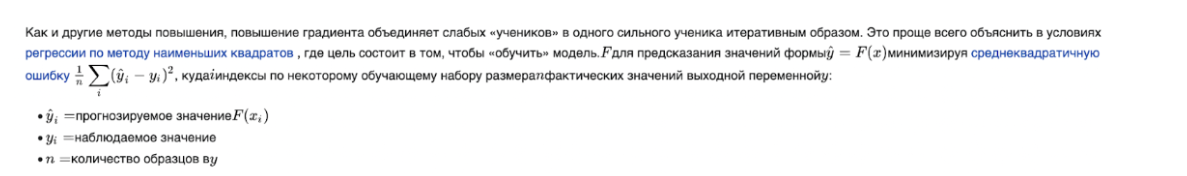

In [147]:
%%time
from sklearn.ensemble import GradientBoostingClassifier
start = time.time()
model = GradientBoostingClassifier().fit(X_train,y_train)
end_train = time.time()
y_predictions = model.predict(X_test) # These are the predictions from the test data.
end_predict = time.time()

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



CPU times: user 31.4 s, sys: 5.17 ms, total: 31.4 s
Wall time: 31.2 s


In [148]:
accuracy = accuracy_score(y_test, y_predictions)
recall = recall_score(y_test, y_predictions, average='weighted')
precision = precision_score(y_test, y_predictions, average='weighted')
f1s = f1_score(y_test, y_predictions, average='weighted')

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("time to train: "+ "{:.2f}".format(end_train-start)+" s")
print("time to predict: "+"{:.2f}".format(end_predict-end_train)+" s")
print("total: "+"{:.2f}".format(end_predict-start)+" s")
model_performance.loc['Gradient Boosting Classifier'] = [accuracy, recall, precision, f1s,end_train-start,end_predict-end_train,end_predict-start]


Accuracy: 95.68%
Recall: 95.68%
Precision: 95.68%
F1-Score: 95.68%
time to train: 31.19 s
time to predict: 0.04 s
total: 31.23 s


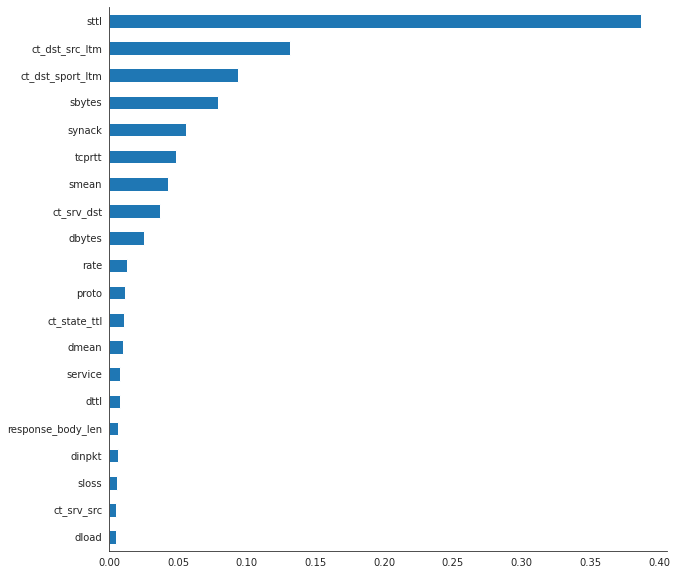

In [149]:
plt.rcParams['figure.figsize']=10,10
sns.set_style("white")
feat_importances = pd.Series(model.feature_importances_, index=feature_names)
feat_importances = feat_importances.groupby(level=0).mean()
feat_importances.nlargest(20).plot(kind='barh').invert_yaxis()
sns.despine()
plt.show()

###Заключение

Выводим таблицу с метриками по моделям. И выбираем саму наилучшую

In [150]:
model_performance.fillna(.90,inplace=True)
model_performance.style.background_gradient(cmap='coolwarm').format({'Accuracy': '{:.2%}',
                                                                     'Precision': '{:.2%}',
                                                                     'Recall': '{:.2%}',
                                                                     'F1-Score': '{:.2%}',
                                                                     'time to train':'{:.1f}',
                                                                     'time to predict':'{:.1f}',
                                                                     'total time':'{:.1f}',
                                                                     })

,Accuracy,Recall,Precision,F1-Score,time to train,time to predict,total time
Isolation forest,48.89%,48.89%,32.41%,38.98%,15.6,7.4,22.9
COPOD,43.24%,43.24%,42.42%,33.12%,1.4,1.4,2.9
MLP,75.53%,75.53%,77.32%,75.50%,25.2,0.0,25.2
Gradient Boosting Classifier,95.68%,95.68%,95.68%,95.68%,31.2,0.0,31.2


Записываем нашу модель в отдельный файл. И применяем ее на тестовых данных

In [151]:
import pickle

In [152]:
filename = 'GradientBoostingClassifier.sav'
pickle.dump(model, open(filename, 'wb'))

In [153]:
loaded_model = pickle.load(open(filename, 'rb'))

In [154]:
data_numeric = data_test.select_dtypes(include=[np.number])
normalize_data(data_numeric)

list_drop = ['id','attack_cat']
drop_col(list_drop,data_test)

cols_cat = ['proto', 'service', 'state']
remove_dump_values(data_test, cols_cat)

label_encoder_transform(data_test,cols_cat)

data_x = data_test.drop(['label'], axis=1)
data_y = data_test.loc[:,['label']]

id
max = 175341
75th = 166574.0
median = 87671.0
False
----------------------------------------------------
dur
max = 59.999989
75th = 3.079511
median = 0.001582
True
----------------------------------------------------
spkts
max = 9616
75th = 64.0
median = 2.0
True
----------------------------------------------------
dpkts
max = 10974
75th = 62.0
median = 2.0
True
----------------------------------------------------
sbytes
max = 12965233
75th = 13662.0
median = 430.0
True
----------------------------------------------------
dbytes
max = 14655550
75th = 39076.0
median = 164.0
True
----------------------------------------------------
rate
max = 1000000.003
75th = 333333.3215
median = 3225.80652
True
----------------------------------------------------
sttl
max = 255
75th = 254.0
median = 254.0
False
----------------------------------------------------
dttl
max = 254
75th = 252.0
median = 29.0
False
----------------------------------------------------
sload
max = 5988000256.0
75th = 2666

In [155]:
result = loaded_model.score(data_x, data_y)
print(result)

0.9043463878955863


###Ссылки

1.  https://en.wikipedia.org/wiki/Isolation_forest
2.  https://research.unsw.edu.au/projects/unsw-nb15-dataset
